<a href="https://colab.research.google.com/github/Archi2903/AI-in-Engenery/blob/main/Main_2_DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load library:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import os

# Change working directory, if needed:
# os.chdir(' ')

# This is for making directories where to save trained model and snapshots:
if os.path.isdir('Trained Models') == False:
    os.mkdir('Trained Models')
if os.path.isdir('snapshots') == False:
    os.mkdir('snapshots')

In [4]:
# Load both training image and MPS 500 MPS realizations
Loaded_data = np.load('/content/drive/MyDrive/Colab Notebooks/Energy AI Jo Proffesor/GAN n DDPM Demo in 2D/MPS_Training_image_and_Realizations_500.npz')
TI = Loaded_data['array1']
MPS_real = Loaded_data['array2']

Text(0, 0.5, 'Y axis, 100 ft')

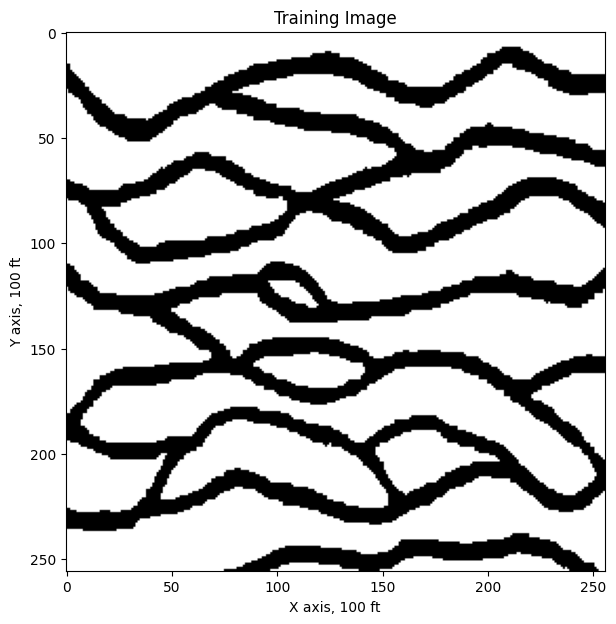

In [5]:
# Visualizae Training image for 2D channel subsurface model:
plt.figure(figsize = (7,7))
plt.imshow(TI, cmap='binary')
plt.title('Training Image')
plt.xlabel('X axis, 100 ft')
plt.ylabel('Y axis, 100 ft')

For more details of GSLIB: https://github.com/GeostatsGuy/GeostatsPy

Total Number of realizations: 500 
The dimension of each reservoir model: 128 x 128 in X and Y


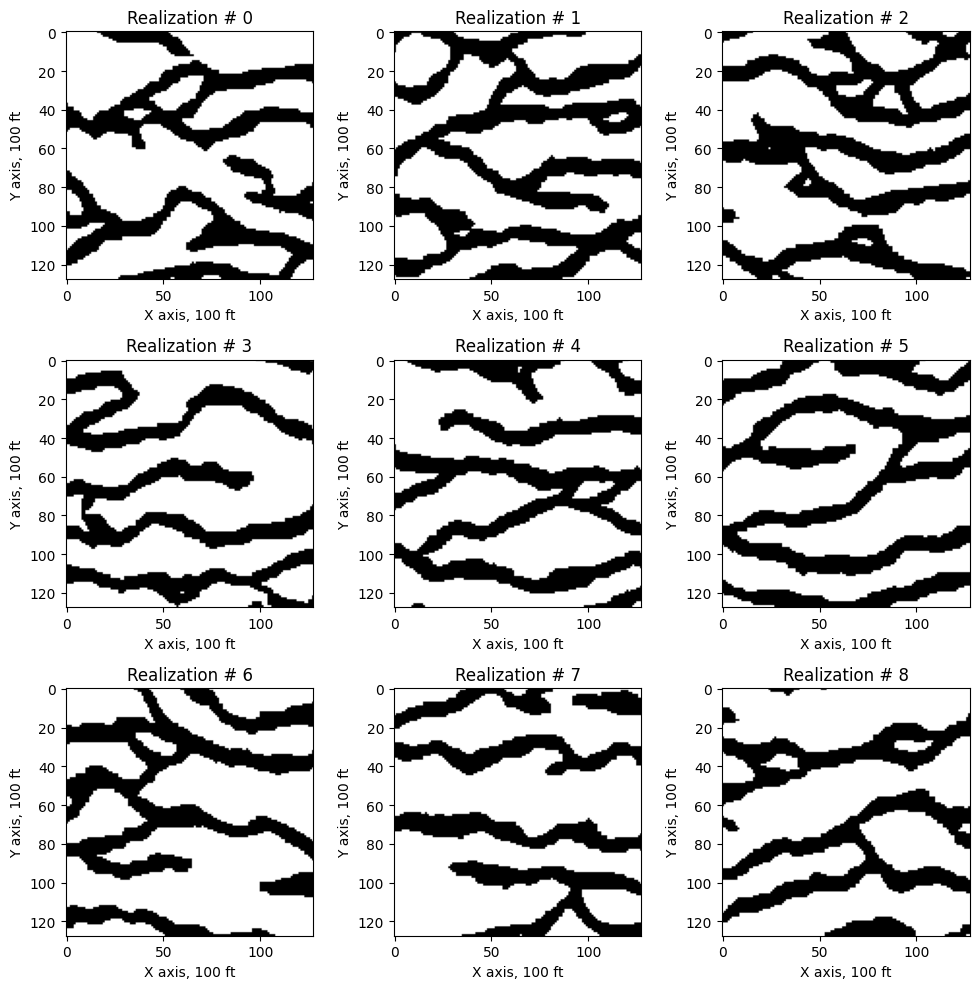

In [6]:
# Visualizae MPS realizations from the above training image:
print('Total Number of realizations: %d \nThe dimension of each reservoir model: %d x %d in X and Y' %(MPS_real.shape[2],MPS_real.shape[0], MPS_real.shape[1]))

plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(MPS_real[:,:,i], cmap='binary')
    plt.title('Realization # %d' %(i))
    plt.xlabel('X axis, 100 ft')
    plt.ylabel('Y axis, 100 ft')
plt.tight_layout()

## Step 1. Define convolutional neural networks for DDPM

In [16]:
from __future__ import print_function, division

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import (
    Input, Dense, Reshape, Flatten, Dropout, BatchNormalization,
    Activation, Conv2D, Conv2DTranspose, LeakyReLU, UpSampling2D,
    Embedding, Lambda, MaxPooling2D, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


class DDPM:
    def __init__(self,
                 img_rows=128,
                 img_cols=128,
                 channels=1,
                 timesteps=1,  # DDPM
                 beta_start=1e-4, #
                 beta_end=0.02,   #
                 learning_rate=2e-4): #


        # --------------------
        #  Model configuration
        # --------------------

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Number of diffusion steps
        self.T = timesteps

        # Linear beta schedule
        betas = np.linspace(beta_start, beta_end, self.T, dtype=np.float32)
        alphas = 1.0 - betas
        alpha_bar = np.cumprod(alphas, axis=0)

        self.beta = betas
        self.alpha = alphas
        self.alpha_bar = alpha_bar

        # TensorFlow constants for training
        self.beta_tf = tf.constant(betas, dtype=tf.float32)
        self.alpha_tf = tf.constant(alphas, dtype=tf.float32)
        self.alpha_bar_tf = tf.constant(alpha_bar, dtype=tf.float32)

        # Optimizer
        self.optimizer = Adam(learning_rate=learning_rate)

        # Build epsilon-theta model (U-Net–style)
        self.model = self.build_unet()
        self.model.summary()

        # Create output folders
        os.makedirs("Snapshots_DDPM", exist_ok=True)
        os.makedirs("Trained_Models_DDPM", exist_ok=True)

    # ------------------------------------------------------------------
    #  Sinusoidal-like timestep embedding (simple Embedding + MLP)
    # ------------------------------------------------------------------
    def time_embedding(self, t_input):
        """
        t_input: integer timestep indices, shape (batch,)
        Returns: embedded tensor shape (batch, 1, 1, 64) for broadcasting
        """
        # Embedding layer: (T, 64)
        x = Embedding(input_dim=self.T, output_dim=64)(t_input)  # (batch, 64)
        x = Dense(64, activation="relu")(x)
        x = Dense(64, activation="relu")(x)
        # Reshape to (batch, 1, 1, 64) for broadcasting to feature maps
        # Fix: Specify output_shape for the Lambda layer
        x = Lambda(lambda z: tf.expand_dims(tf.expand_dims(z, axis=1), axis=1), output_shape=(1, 1, 64))(x)
        return x

    # ------------------------------------------------------------------
    #  Small 2D U-Net for noise prediction ε_θ(x_t, t)
    # ------------------------------------------------------------------
    def build_unet(self):
        img_in = Input(shape=self.img_shape, name="x_t")
        t_in = Input(shape=(), dtype="int32", name="timestep")

        # Timestep embedding
        t_emb = self.time_embedding(t_in)  # (batch, 1, 1, 64)

        # ---------------- Encoder ----------------
        # Block 1
        x = Conv2D(64, kernel_size=3, padding="same")(img_in)
        x = x + t_emb  # inject time info
        x = Activation("relu")(x)
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        skip1 = x
        x = MaxPooling2D(pool_size=(2, 2))(x)  # 128 -> 64

        # Block 2
        x = Conv2D(128, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(128, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        skip2 = x
        x = MaxPooling2D(pool_size=(2, 2))(x)  # 64 -> 32

        # Bottleneck
        x = Conv2D(256, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(256, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)

        # ---------------- Decoder ----------------
        # Up-block 1
        x = UpSampling2D(size=(2, 2))(x)  # 32 -> 64
        x = Conv2D(128, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = Concatenate()([x, skip2])
        x = Conv2D(128, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)

        # Up-block 2
        x = UpSampling2D(size=(2, 2))(x)  # 64 -> 128
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)
        x = Concatenate()([x, skip1])
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = Activation("relu")(x)

        # Output: predicted noise ε
        out = Conv2D(self.channels, kernel_size=1, padding="same", activation="linear")(x)

        return Model([img_in, t_in], out, name="ddpm_unet")

    # ------------------------------------------------------------------
    #  Forward diffusion: q(x_t | x_0)
    #  x_t = sqrt(α̅_t) * x_0 + sqrt(1 - α̅_t) * ε
    # ------------------------------------------------------------------
    def q_sample(self, x0, t, noise=None):
        """
        x0: original images in [0, 1], shape (B, H, W, C)
        t: integer timesteps, shape (B,)
        noise: optional Gaussian noise; if None, sampled internally
        """
        if noise is None:
            noise = tf.random.normal(shape=tf.shape(x0))

        alpha_bar_t = tf.gather(self.alpha_bar_tf, t)  # (B,)
        alpha_bar_t = tf.reshape(alpha_bar_t, (-1, 1, 1, 1))

        sqrt_alpha_bar = tf.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar = tf.sqrt(1.0 - alpha_bar_t)

        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise

    # ------------------------------------------------------------------
    #  One training step: minimize || ε - ε_θ(x_t, t) ||^2
    # ------------------------------------------------------------------
    @tf.function
    def train_step(self, x0):
        """
        x0: batch of clean images in [0, 1], shape (B, 128, 128, 1)
        """
        batch_size = tf.shape(x0)[0]
        # Sample random timesteps in [1, T)
        t = tf.random.uniform(shape=(batch_size,),
                              minval=1,
                              maxval=self.T,
                              dtype=tf.int32)

        # Sample noise and generate x_t
        noise = tf.random.normal(shape=tf.shape(x0))
        x_t = self.q_sample(x0, t, noise)

        with tf.GradientTape() as tape:
            eps_pred = self.model([x_t, t], training=True)
            # MSE between true noise and predicted noise
            loss = tf.reduce_mean(tf.square(noise - eps_pred))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        return loss

    # ------------------------------------------------------------------
    #  Sampling: p_θ(x_{t-1} | x_t)
    #  Using the standard DDPM update:
    #  x_{t-1} = 1/sqrt(α_t) * (x_t - β_t / sqrt(1-α̅_t) * ε_θ(x_t,t)) + σ_t z
    #  with σ_t = sqrt(β_t)
    # ------------------------------------------------------------------
    def sample(self, n_samples=25):
        """
        Generate n_samples images by reverse diffusion.
        Returns: numpy array, shape (n_samples, H, W, C), values in [0,1] approximately.
        """
        # Start from pure Gaussian noise
        x_t = tf.random.normal(shape=(n_samples, self.img_rows, self.img_cols, self.channels))

        for t_idx in reversed(range(self.T)):
            t = tf.fill((n_samples,), t_idx)  # all samples share same timestep
            eps_theta = self.model.predict([x_t, t], verbose=0)

            beta_t = self.beta[t_idx]
            alpha_t = self.alpha[t_idx]
            alpha_bar_t = self.alpha_bar[t_idx]

            # Coefficients for update
            sqrt_one_minus_alpha_bar_t = np.sqrt(1.0 - alpha_bar_t)
            sqrt_alpha_t_inv = 1.0 / np.sqrt(alpha_t)

            # Equation from DDPM paper
            x_t = sqrt_alpha_t_inv * (
                x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * eps_theta
            )

            if t_idx > 0:
                z = tf.random.normal(shape=tf.shape(x_t))
                sigma_t = np.sqrt(beta_t)
                x_t = x_t + sigma_t * z

        # Optionally clip to [0,1]
        x_0 = tf.clip_by_value(x_t, 0.0, 1.0)
        return x_0.numpy()

    # ------------------------------------------------------------------
    #  Utilities for visualization and saving
    # ------------------------------------------------------------------
    def save_imgs(self, step, n_samples=25):
        r, c = 5, 5
        gen_imgs = self.sample(n_samples=r * c)

        fig, axs = plt.subplots(r, c, figsize=(8, 8))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap="binary")
                axs[i, j].axis("off")
                cnt += 1

        fig.tight_layout()
        fig.savefig(f"Snapshots_DDPM/samples_{step:06d}.png")
        plt.close(fig)

    def save_model(self, step):
        path = f"Trained_Models_DDPM/DDPM_Epoch_{step:06d}.keras"
        self.model.save(path)

    # ------------------------------------------------------------------
    #  Main training loop (similar in style to your GAN.train)
    # ------------------------------------------------------------------
    def train(self, X_train, epochs, batch_size=32, save_interval=100):
        """
        X_train: numpy array, shape (N, 128, 128, 1), values in [0,1]
        epochs: number of training iterations (not full dataset epochs)
        """
        X_train = X_train.astype("float32")
        n_samples = X_train.shape[0]

        for step in range(epochs):
            # Sample random batch
            idx = np.random.randint(0, n_samples, batch_size)
            x0 = X_train[idx]

            loss = self.train_step(x0)

            if step % 100 == 0:
                print(f"Step {step} | DDPM loss: {float(loss):.6f}")

            if step % save_interval == 0:
                self.save_imgs(step)
                self.save_model(step)

In [17]:
# Load training data
X_train = MPS_real.reshape(128,128,1,500)
X_train = np.moveaxis(X_train,-1,0)

# Instantiate DDPM
ddpm = DDPM(timesteps=1000) # Fix: Initialize with appropriate timesteps, e.g., 1000

ddpm.train( X_train=X_train,
            epochs=2001,        # number of training iterations
            batch_size=32,
            save_interval=500   # save samples & model
            )

Model: "ddpm_unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timestep            │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 64)        │     64,000 │ timestep[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_t (InputLayer)    │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │        640 │ x_t[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 1, 64)  │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 128,  │          0 │ conv2d_22[0][0],  │
│                     │ 64)               │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ add_2[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_20[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ conv2d_23[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_22[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 64, 64,    │          0 │ conv2d_25[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ activation_23[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[

 Total params: 1,954,305 (7.46 MB)

 Trainable params: 1,954,305 (7.46 MB)

 Non-trainable params: 0 (0.00 B)

Step 0 | DDPM loss: 1.032248


KeyboardInterrupt: 

## Step 2. Load the trainined DDPM

In [18]:
from keras.models import load_model # this is for loading NN models

In [19]:
# ---- Must match the values used in DDPM training ----
IMG_SIZE = 128
CHANNELS = 1
T = 1000            # timesteps
BETA_START = 1e-4
BETA_END   = 0.02

betas  = np.linspace(BETA_START, BETA_END, T, dtype=np.float32)
alphas = 1.0 - betas
alpha_bar = np.cumprod(alphas, axis=0)


def ddpm_sample_from_checkpoint(ckpt_path, n_samples=1, safe_mode=False):
    model = tf.keras.models.load_model(
        ckpt_path,
        compile=False,
        safe_mode=safe_mode
    )
    # Load model (must be same architecture as training)
    ddpm_model = load_model(checkpoint_path)

    # Start from Gaussian noise
    x_t = tf.random.normal(shape=(n_samples, IMG_SIZE, IMG_SIZE, CHANNELS))

    for t_idx in reversed(range(T)):
        # timestep tensor (batch, )
        t = tf.fill((n_samples,), t_idx)

        # Predict noise ε_θ(x_t, t)
        eps_theta = ddpm_model.predict([x_t, t], verbose=0)

        beta_t = betas[t_idx]
        alpha_t = alphas[t_idx]
        alpha_bar_t = alpha_bar[t_idx]

        sqrt_one_minus_alpha_bar_t = np.sqrt(1.0 - alpha_bar_t)
        sqrt_alpha_t_inv = 1.0 / np.sqrt(alpha_t)

        # x_{t-1} = 1/sqrt(α_t) * (x_t - β_t / sqrt(1-α̅_t) * ε_θ)
        x_t = sqrt_alpha_t_inv * (
            x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * eps_theta
        )

        # Add noise except at t = 0
        if t_idx > 0:
            z = tf.random.normal(shape=tf.shape(x_t))
            sigma_t = np.sqrt(beta_t)
            x_t = x_t + sigma_t * z

    x_0 = tf.clip_by_value(x_t, 0.0, 1.0)
    return x_0.numpy()


NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_125>',)
  • kwargs={'mask': 'None'}

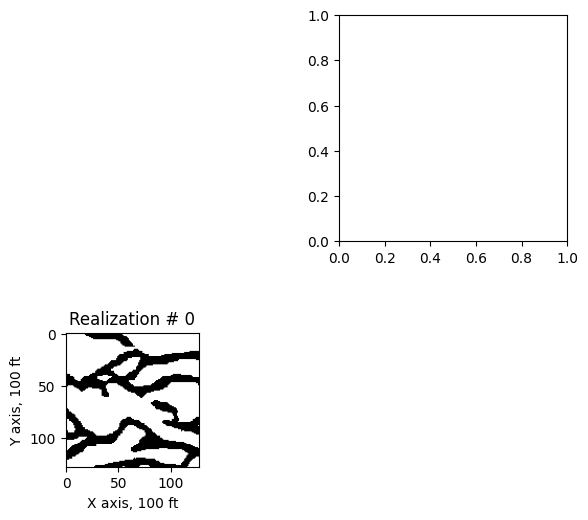

In [20]:
# ---- Choose which real realization to show ----

real_idx = 0  # e.g., first slice MPS_real[:, :, 0]

plt.figure(figsize=(10, 10))

# (1) Real MPS realization
plt.subplot(1, 5, 1)
plt.imshow(MPS_real[:, :, real_idx], cmap='binary')
plt.title(f'Realization # {real_idx}')
plt.xlabel('X axis, 100 ft')
plt.ylabel('Y axis, 100 ft')

# ---- "epochs" here are actually DDPM training steps used when saving ----
# Adjusted steps to match the save_interval=1000 used during training
steps = [0,500,1000,1500,2000]

for idx, step in enumerate(steps):
    # Ensure we don't try to plot more than 9 images (1 real + 8 generated)
    if idx + 2 > 9:
        break
    plt.subplot(3, 3, idx + 2)  # positions 2..9

    ckpt_path = f"Trained_Models_DDPM/DDPM_Epoch_{step:06d}.keras"

    # Generate one DDPM sample from this checkpoint
    samples = ddpm_sample_from_checkpoint(ckpt_path, n_samples=1, safe_mode=False)
    img = samples[0, :, :, 0]  # (128, 128)

    plt.imshow(img, cmap='binary')
    plt.title(f'DDPM realization - step {step}')
    plt.xlabel('X axis, 100 ft')
    plt.ylabel('Y axis, 100 ft')

plt.tight_layout()
plt.show()

## 0 epoch
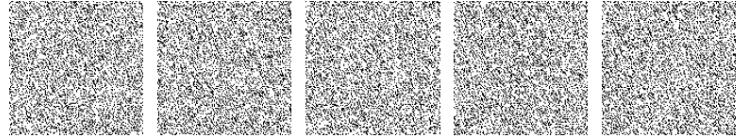

## 500 epoch
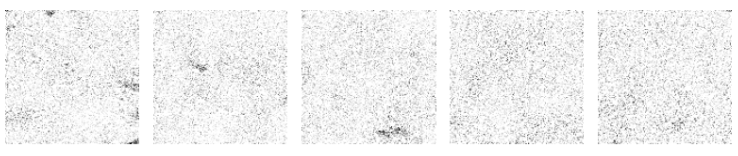

## 1000 epoch
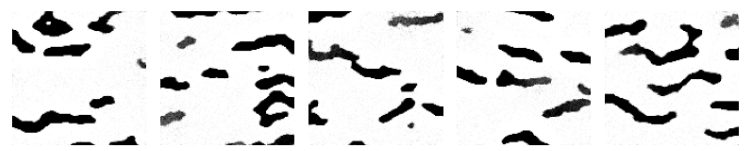

## 1500 epoch
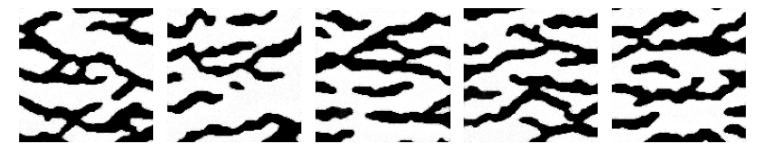

## 2000 epoch
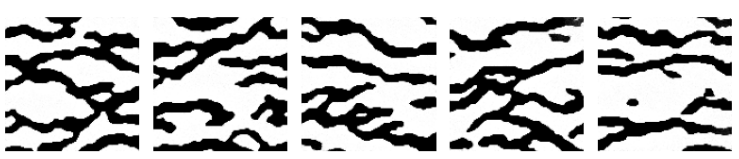